# Nanopore Adenocarcinoma Binary Classification
Andrew E. Davidson  
aedavids@ucsc.edu  
4/24/24  

Copyright (c) 2020-2023, Regents of the University of California All rights reserved. 
https://polyformproject.org/licenses/noncommercial/1.0.0

ref: extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/elifeBinaryRandomForestResults.ipynb

In [1]:
import ipynbname

# use display() to print an html version of a data frame
# useful if dataFrame output is not generated by last like of cell
from IPython.display import display

import joblib
# import math
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_rows', None)
# import pprint as pp
import matplotlib.pyplot as plt

# import scikitplot as skplt

from sklearn.ensemble        import RandomForestClassifier

# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score

# from sklearn.model_selection import cross_val_score, cross_validate
# from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.tree import plot_tree

import sys

notebookName = ipynbname.name()
notebookPath = ipynbname.path()
notebookDir = os.path.dirname(notebookPath)

# #outDir = f'{notebookDir}/{notebookName}.out'
# outDir = f'/private/groups/kimlab/aedavids/elife/{notebookName}.out'
# os.makedirs(outDir, exist_ok=True)
# print(f'outDir:\n{outDir}')

# modelOutDir = os.path.join(outDir, "model")
# os.makedirs(modelOutDir, exist_ok=True)
# print(f'\nmodelOutDir ;\n{modelOutDir}')

# # results of hyperparmeter search
# hyperparameterOut = "/private/groups/kimlab/aedavids/elife/hyperparmeterTunning"

# imgOut = f'{outDir}/img'
# os.makedirs(imgOut, exist_ok=True)
# print(f'\nimgOut :\n{imgOut}')

import logging
# loglevel = "INFO"
loglevel = "WARN"
# logFMT = "%(asctime)s %(levelname)s [thr:%(threadName)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logFMT = "%(asctime)s %(levelname)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logging.basicConfig(format=logFMT, level=loglevel)    
logger = logging.getLogger(notebookName)

meaningOfLife = 42

/data/tmp/ipykernel_2441731/4185059269.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# ! pwd
! ls ../../intraExtraRNA_POC/python/src

confusion_matrix  intraExtraRNA  models  tmp


In [3]:
# setting the python path allows us to run python scripts from using
# the CLI. 
ORIG_PYTHONPATH = os.environ['PYTHONPATH']

deconvolutionModules = notebookPath.parent.joinpath("../../deconvolutionAnalysis/python/")
print("deconvolutionModules: {}\n".format(deconvolutionModules))

PYTHONPATH = ORIG_PYTHONPATH + f':{deconvolutionModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

intraExtraRNA_POCModules=notebookPath.parent.joinpath("../../intraExtraRNA_POC/python/src")
print("intraExtraRNA_POCModules: {}\n".format(intraExtraRNA_POCModules))

PYTHONPATH = PYTHONPATH + f':{intraExtraRNA_POCModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

os.environ["PYTHONPATH"] = PYTHONPATH
PYTHONPATH = os.environ["PYTHONPATH"]
print("PYTHONPATH: {}\n".format(PYTHONPATH))

# to be able to import our local python files we need to set the sys.path
# https://stackoverflow.com/a/50155834
sys.path.append( str(deconvolutionModules) )
sys.path.append( str(intraExtraRNA_POCModules) )
print("\nsys.path:\n{}\n".format(sys.path))

deconvolutionModules: /private/home/aedavids/extraCellularRNA/londonCalling2024/jupyterNotebooks/../../deconvolutionAnalysis/python

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/londonCalling2024/jupyterNotebooks/../../deconvolutionAnalysis/python

intraExtraRNA_POCModules: /private/home/aedavids/extraCellularRNA/londonCalling2024/jupyterNotebooks/../../intraExtraRNA_POC/python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/londonCalling2024/jupyterNotebooks/../../deconvolutionAnalysis/python:/private/home/aedavids/extraCellularRNA/londonCalling2024/jupyterNotebooks/../../intraExtraRNA_POC/python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/londonCalling2024/jupyterNotebooks/../../deconvolutionAnalysis/python:/private/home/aedavids/extraCellularRNA/londonCalling2024/jupyterNotebooks/../../intraExtraRNA_POC/python/src


sys.p

In [4]:
# import local 
# from analysis.utilities import findFile
from analysis.utilities import loadDictionary
from analysis.utilities import loadList
# from analysis.utilities import saveDictionary
# from intraExtraRNA.elifeUtilities import loadElifeTrainingData
from intraExtraRNA.elifeUtilities import searchForMissingMapGenes
from intraExtraRNA.elifeUtilities import selectFeatures
from intraExtraRNA.utilities import  selectSamples

from models.mlUtilities import encoder2Dict
from models.mlUtilities import loadEncoder

# # from models.randomForestHyperparmeterSearch import createScoringMetricsDict
# # from models.randomForestHyperparmeterSearch import evaluateModel
# # # from models.randomForestHyperparmeterSearch import tunningFramework
# from models.plotROC import plotROC
from models.plotROC import plotROCWrapper
# from pipeline.dataFactory.utilities import urlify

# Select Model

**results**  

elife-Esophagus-Cancer-Health-control-random-forest-GTEx-Esophagus_Mucosa-biomarkers  
```
yNP:
[0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1]

predictions:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
```

In [5]:
# modelName="elife-Esophagus-Cancer-Health-control-random-forest-GTEx-Esophagus_Mucosa-biomarkers"
# biomarkerSetName="Esophagus_Mucosa"

# modelName="elife-Esophagus-Cancer-Health-control-random-forest-GTEx-Esophagus_Muscularis-biomarkers"
# biomarkerSetName="Esophagus_Muscularis"

# modelName="elife-Esophagus-Cancer-Health-control-random-forest-GTEx-Esophagus_Gastroesophageal_Junction-biomarkers"
# biomarkerSetName="Esophagus_Gastroesophageal_Junction"

modelName="elife-Esophagus-Cancer-Health-control-random-forest-GTEx-Esophagus_ESCA-biomarkers"
biomarkerSetName="ESCA"

# load our pretrained random forest model

In [6]:
modelOut = "/private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/model"
modelPath = f"{modelOut}/{modelName}.joblib"
model = joblib.load(modelPath)
print(f'loaded model: {modelPath}')

loaded model: /private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/model/elife-Esophagus-Cancer-Health-control-random-forest-GTEx-Esophagus_ESCA-biomarkers.joblib


In [7]:
featureImportancePath = f"{modelOut}/{modelName}_featureImportance.txt"
featureImportanceDict = loadDictionary( featureImportancePath )
featureImportanceDict

{'(TA)n': 0.11118256627883959,
 'AC010336.3': 0.1924857767825337,
 'AC012615.3': 0.12967970818363103,
 'CCDC160': 0.052167275069954895,
 'GOLGA8S': 0.07120700522622316,
 'HERVFH19-int': 0.031033098618658585,
 'LTR106': 0.1293855224600125,
 'MER5C': 0.20119727257964382,
 'PRELID1P1': 0.036690199143120335,
 'UBE2SP2': 0.04497157565738244}

In [8]:
featureNamesPath = f"{modelOut}/{modelName}_features.txt"
featureNames = loadList(featureNamesPath)
featureNames

['AC012615.3',
 '(TA)n',
 'UBE2SP2',
 'HERVFH19-int',
 'PRELID1P1',
 'LTR106',
 'AC010336.3',
 'GOLGA8S',
 'MER5C',
 'CCDC160']

In [9]:
encoderPath = f'{modelOut}/{modelName}.labelEncoder.txt'
labelEncoder = loadEncoder(encoderPath)
print(f'labelEncoder: \n{encoder2Dict(labelEncoder)}')
classes = labelEncoder.classes_
print(f'labelEncoder classes :\n{classes}')

labelEncoder: 
{'Esophagus Cancer': 0, 'Healthy donor': 1}
labelEncoder classes :
['Esophagus Cancer' 'Healthy donor']


In [10]:
print(f'modelName : {modelName}')
model

modelName : elife-Esophagus-Cancer-Health-control-random-forest-GTEx-Esophagus_ESCA-biomarkers


RandomForestClassifier(max_depth=7, max_features=1, max_samples=0.9,
                       n_estimators=50, random_state=42)

figure out what category the model expects

# Plot the first tree
provides evidence that we loaded the model correctly and know what int values the classes require

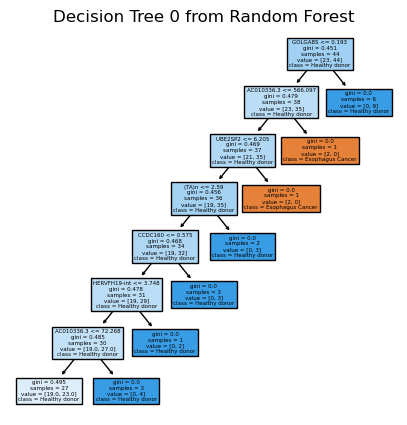

In [11]:
# Select one tree from the forest
tree_index = 0  # selecting the first tree
singleTree = model.estimators_[tree_index]

# Plot the selected tree
plt.figure(figsize=(5,5))
# plot_tree(singleTree, filled=True, feature_names=['sepal length', 'sepal width', 'petal length', 'petal width'], class_names=['Setosa', 'Versicolor', 'Virginica'])
plot_tree(singleTree, 
          filled=True, 
          feature_names=featureNames,
          class_names=classes, #['zero', 'one'],
         )
plt.title(f"Decision Tree {tree_index} from Random Forest")
plt.show()

# Load the data

In [12]:
%%time
countPathRoot = "/private/groups/kimlab/vikas/nanopore/promethion/barretts/analysis/complete-seq/R_results"
countHighPath = f'{countPathRoot}/normalized_counts_for_andy.csv'
highCountDF = pd.read_csv(countHighPath, index_col="rowname")
print(f'loading:\n{countHighPath}')
highCountDF.index = highCountDF.index.rename('geneId')
highCountNumSamples = highCountDF.shape[1] - 1
print(f'highCountDF.shape : {highCountDF.shape} highCountNumSamples: {highCountNumSamples}')

# set flag we need to filter colData
isHighCountDF = True

highCountDF.head()

loading:
/private/groups/kimlab/vikas/nanopore/promethion/barretts/analysis/complete-seq/R_results/normalized_counts_for_andy.csv
highCountDF.shape : (360992, 26) highCountNumSamples: 25
CPU times: user 595 ms, sys: 102 ms, total: 697 ms
Wall time: 696 ms


,complete_06f7c.demux_recovered,complete_0c248.demux_recovered,complete_21aef.demux_recovered,complete_38349.demux_recovered,complete_3e0cd.demux_recovered,complete_424dd.demux_recovered,complete_69d84.demux_recovered,complete_73d9f.demux_recovered,complete_7a4ec.demux_recovered,complete_82408.demux_recovered,...,complete_decfd.demux_recovered,complete_e6242.demux_recovered,complete_fcc51.demux_recovered,complete_HMN1208728.demux_recovered,complete_HMN1208743.demux_recovered,complete_HMN1208751.demux_recovered,complete_HMN1233837.demux_recovered,complete_HMN1233838.demux_recovered,complete_HMN1233843.demux_recovered,complete_HMN1233849.demux_recovered
geneId,,,,,,,,,,,,,,,,,,,,,
(A)n,1105,980,466,1053,632,1476,1172,460,1658,731,...,1737,1186,1050,2409,1339,894,371,274,352,277
(AAA)n,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(AAAAAAC)n,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
(AAAAAAG)n,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(AAAAAAT)n,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
%%time
rootDir = "/private/groups/kimlab/aedavids/londonCalling2024/data"
colDataPath = f'{rootDir}/colData.csv'
print(f'colDataPath {colDataPath}')
colDataDF = pd.read_csv(colDataPath)
print(f'colDataDF.shape : {colDataDF.shape}')
colDataDF.head(n=10)

colDataPath /private/groups/kimlab/aedavids/londonCalling2024/data/colData.csv
colDataDF.shape : (44, 11)
CPU times: user 4.28 ms, sys: 0 ns, total: 4.28 ms
Wall time: 3.13 ms


,sampleId,countType,sex,age,race,histology,batchID,sample,suffix,sampleIdToken,barcode
0,complete_82408.demux_recovered,high,male,76.2,NaN,adenocarcinoma,batch1,07dab69dfdd8e6518a7ff39b0669d029bbdce978598ce6...,82408,82408,1.0
1,complete_d1030.demux_recovered,high,male,76.4,NaN,adenocarcinoma,batch1,3fff03c9f87217265b27301425821d28012ec9572f6066...,d1030,d1030,2.0
2,complete_c43de.demux_recovered,high,male,68.7,NaN,adenocarcinoma,batch1,493bf7322b8c18365466c43bf7a9e119bd4d7782147f9b...,c43de,c43de,3.0
3,complete_abbe0.demux_recovered,high,male,80.1,NaN,adenocarcinoma,batch1,71e1e767626b62a9dfb5321155050864a42c3bd00fe6d5...,abbe0,abbe0,4.0
4,complete_0c248.demux_recovered,high,male,85.3,NaN,high grade dysplasia,batch1,55153c626632da62c806b937e843029d8ebdf443339f09...,0c248,0c248,5.0
5,complete_424dd.demux_recovered,high,male,61.4,NaN,high grade dysplasia,batch1,74ffea6045f9ff44c0e3b46fe32fa30de6e616cd174fa3...,424dd,424dd,6.0
6,complete_73d9f.demux_recovered,high,male,70.3,NaN,high grade dysplasia,batch1,c4e21ec2e0d0ddc2d67b423f88afbb70efbccfe6771696...,73d9f,73d9f,7.0
7,complete_fcc51.demux_recovered,high,male,64.5,NaN,high grade dysplasia,batch1,fc8312805a7b522dd76f2fb66a10f680c19270dd7bda4e...,fcc51,fcc51,8.0
8,complete_HMN1233843.demux_recovered,high,male,72.0,NaN,control,batch1,HMN1233843,33843,HMN1233843,9.0
9,complete_HMN1233844.demux_recovered,low,male,70.0,NaN,control,batch1,HMN1233844,33844,HMN1233844,10.0


In [14]:
if isHighCountDF:
    print(f'!!!!!!!!!! warning isHighCountDF == True. We need to filter')
    selectHighCountRows = colDataDF.loc[:,"countType"] == "high"
    colDataDF = colDataDF.loc[selectHighCountRows, :]
    print(f'colDataDF.shape : {colDataDF.shape}')


!!!!!!!!!! warning isHighCountDF == True. We need to filter
colDataDF.shape : (26, 11)


In [15]:
colDataDF.groupby("histology").count()#.loc[selectElifeCategories, :]

,sampleId,countType,sex,age,race,batchID,sample,suffix,sampleIdToken,barcode
histology,,,,,,,,,,
adenocarcinoma,12,12,12,12,0,12,12,12,12,12
control,7,7,7,7,6,7,7,7,7,7
high grade dysplasia,7,7,7,7,0,7,7,7,7,7


# convert count data to format model expects

In [16]:
colDataDF.loc[:,'histology'].unique()

array(['adenocarcinoma', 'high grade dysplasia', 'control'], dtype=object)

In [17]:
def renameCategory(metaDF : pd.DataFrame, src : str, to : str):
    selectRows = metaDF.loc[:, 'category'] == src
    metaDF.loc[selectRows, 'category'] = to
    return metaDF

In [18]:
%%time
def createDataInPredictionFormat(
        countDF : pd.DataFrame,
        colData : pd.DataFrame,
        features : list[str]
    ) -> tuple[np.array, np.array, list[str], list[str]]:
    '''
    convert count and colData into numpy arrays

    arguments:
        countDF

        features
            a list of hugo gene names

    returns:
        (XNP, yNP, genes, missingGenes)

        Our model where trained using the GTEx_TCGA data set.
        The biomarkers where reported using HUGO and repeat names.

        new version of complete-seq using ENSGO names. The genes
        list contains the ENSGO versions of the biomarkers. missingGenes
        is a list of biomarkers that we where not able to map to ENSGO.
        Typically this is bacause of a id version number mismatch

    '''
    # check for missing biomarkers
    transposedCountDF = countDF.transpose()
    elifeGenes, missingElifeGenes = selectFeatures(transposedCountDF, features)

    # debug
    print(f'elifeGenes:\n{elifeGenes}\n')
    print(f'missingElifeGenes:\n{missingElifeGenes}\n')
    
    # for now just drop missing genes
    features = list( set(elifeGenes) - set(missingElifeGenes) )
    assert len(features) > 0, "ERROR NO FEATURES FOUND"
    
    # create labels
    print(f'!!!!!!! warning do not hard code meta data transformation !!!!!!!!!!')
    metaDF = colDataDF
    tmpMetaDF = metaDF.rename( columns={ "histology" : "category", 'sampleId' : 'sample_id'} )
    
    # we need to change 
    #     adenocarcinoma to Esophagus Cancer'
    #     control to 'Healthy donor'
    
    tmpMetaDF = renameCategory(tmpMetaDF, "adenocarcinoma", 'Esophagus Cancer')
    tmpMetaDF = renameCategory(tmpMetaDF, "control", 'Healthy donor')

    # create sample data
    selectElifeCategories = ['Esophagus Cancer', 'Healthy donor']
    # countDF = countDF.transpose()
    XDF = selectSamples(tmpMetaDF, transposedCountDF, selectElifeCategories)
    XDF = XDF.loc[:, features]
    XNP = XDF.values    
    logger.info(f'XNP.shape : {XNP.shape}')
    
    # create sample labels
    selectRows = tmpMetaDF.loc[:, 'category'].isin(selectElifeCategories)
    conditionList = tmpMetaDF.loc[selectRows, 'category'].tolist()
    
    yNP = labelEncoder.transform(conditionList)
    logger.info(f'yNP.shape : {yNP.shape}')

    return (XNP, yNP, elifeGenes, missingElifeGenes)

tt = createDataInPredictionFormat(highCountDF,colDataDF, featureNames)
XNP, yNP, featureGenes, missingGenes  = tt

2024-04-26 10:33:40,646 WARNING intraExtraRNA.elifeUtilities selectFeatures() line:460] [missingV35IdsSet HUGO or repeat ids from /private/groups/kimlab/genomes.annotations/gencode.35/gencode.v35.ucsc.rmsk.tx.to.gene.csv
set()]


elifeGenes:
['LTR106_Mam', 'ENSG00000217325.2', 'MER5C', 'ENSG00000224126.2', 'ENSG00000261739.2', 'HERVFH19-int', 'ENSG00000268120.1', 'ENSG00000203952.9', '(TA)n', 'ENSG00000267125.2']

missingElifeGenes:
[]

!!!!!!! warning do not hard code meta data transformation !!!!!!!!!!
CPU times: user 23.5 s, sys: 3.45 s, total: 27 s
Wall time: 27 s


In [19]:
print(f'featureGenes:\n{featureGenes}\n')
print(f'missingGenes:\n{missingGenes}\n')

featureGenes:
['LTR106_Mam', 'ENSG00000217325.2', 'MER5C', 'ENSG00000224126.2', 'ENSG00000261739.2', 'HERVFH19-int', 'ENSG00000268120.1', 'ENSG00000203952.9', '(TA)n', 'ENSG00000267125.2']

missingGenes:
[]



# Make predictions and evaluate

In [20]:
print(f'yNP:\n{yNP}')

predictions  = model.predict(XNP)
print(f'\npredictions:\n{predictions}')

yProbability = model.predict_proba(XNP)
print(f'\nyProbability:\n{yProbability}')

yNP:
[0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1]

predictions:
[0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 1]

yProbability:
[[0.58666667 0.41333333]
 [0.62       0.38      ]
 [0.55585714 0.44414286]
 [0.64       0.36      ]
 [0.52416667 0.47583333]
 [0.44       0.56      ]
 [0.6        0.4       ]
 [0.46       0.54      ]
 [0.56138655 0.43861345]
 [0.6        0.4       ]
 [0.688      0.312     ]
 [0.37151034 0.62848966]
 [0.58       0.42      ]
 [0.51586364 0.48413636]
 [0.52683766 0.47316234]
 [0.505171   0.494829  ]
 [0.457171   0.542829  ]
 [0.51374242 0.48625758]
 [0.38112554 0.61887446]]


In [21]:
XNP

array([[  5,   1,  16,   0,   1,   9,   1,   0, 104,   0],
       [  4,   0,  19,   0,   2,   4,   0,   0,  96,   0],
       [  5,   0,  14,   0,   2,   7,   0,   0,  72,   0],
       [ 11,   0,  29,   0,   1,   5,   0,   0, 108,   0],
       [  6,   1,  16,   0,   1,   9,   0,   0,  80,   0],
       [ 20,   2,  49,   0,   5,  13,   0,   0, 198,   0],
       [  7,   1,  45,   0,   1,   7,   0,   0, 163,   0],
       [ 10,   1,  47,   0,   4,  13,   0,   0, 229,   1],
       [  2,   0,  17,   0,   5,  21,   0,   0,  61,   0],
       [ 12,   1,  56,   0,   4,  15,   0,   0, 362,   0],
       [  8,   0,  14,   0,   1,   7,   0,   0, 113,   0],
       [  1,   0,   5,   0,   0,   3,   0,   0,  49,   0],
       [  8,   0,  23,   0,   2,   7,   0,   0,  92,   0],
       [  3,   1,  15,   0,   0,  12,   0,   0, 119,   0],
       [  1,   0,  18,   0,   0,   4,   0,   0, 133,   0],
       [  4,   0,  13,   0,   0,   3,   0,   0, 126,   0],
       [  5,   0,  20,   0,   0,   3,   0,   0, 161,   0

# Plot 

yNP.shape : (19,)
yProbability.shape : (19, 2)


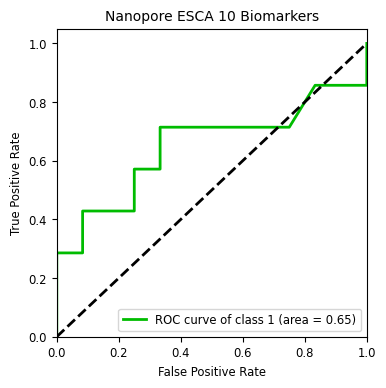

In [28]:
title = f"Nanopore {biomarkerSetName} 10 Biomarkers"
fig, axs, aucDict = plotROCWrapper(XNP, yNP, model, title) # , classesToPlot=[1]

# <span style="color:red;background-color:yellow">BONE YARD</span>

In [23]:
aedwip

NameError: name 'aedwip' is not defined

In [ ]:
txt2GeneFilePath =  "/private/groups/kimlab/genomes.annotations/gencode.35/gencode.v35.ucsc.rmsk.tx.to.gene.csv"
genes = ['AC012615.3', '(TA)n', 'UBE2SP2', 'HERVFH19-int', 'PRELID1P1', 'LTR106', 'AC010336.3', 'GOLGA8S', 'MER5C', 'CCDC160']

In [ ]:
tx2GeneDF = pd.read_csv(txt2GeneFilePath, names=['uberId', 'geneId'])
transcriptDF = tx2GeneDF

In [ ]:
print(f'tx2GeneDF.shape : {tx2GeneDF.shape}')
display(tx2GeneDF.head())
display(tx2GeneDF.tail())

In [ ]:
# if you try and split a tx id that does not have "|" like the repeats
# you get back columns filled with None    
# we can use this to separate the genecode and the repeat mask porition of the data frame
geneCodeMapDF = transcriptDF.loc[:, 'uberId'].str.split('|', expand=True).loc[:, [5, 1, 7]]
geneCodeMapDF.columns = ['HUGO', 'ENSG', 'bioType']
# do not drop. wait till we get idx of repeat mask
# geneCodeMapDF.dropna(inplace=True)
# geneCodeMapDF.drop_duplicates(inplace=True)

In [ ]:
print(f'geneCodeMapDF.shape : {geneCodeMapDF.shape}')
display(geneCodeMapDF.head())
display(geneCodeMapDF.tail())

In [ ]:
tx2GeneDF.loc[5837317, :]

In [ ]:
# if HUGO	ENSG	bioType == None, the row is part of the repeat mask
# selectRepeatMapRows = (geneCodeMapDF.loc[:,"HUGO"] == None) & (geneCodeMapDF.loc[:,"ENSG"] == None) & (geneCodeMapDF.loc[:,"bioType"] == None)
selectRepeatMapRows = (geneCodeMapDF.loc[:,"HUGO"].isna()) & (geneCodeMapDF.loc[:,"ENSG"].isna()) & (geneCodeMapDF.loc[:,"bioType"].isna())


In [ ]:
print( f'len(selectRepeatMapRows) : {len(selectRepeatMapRows)} sum(selectRepeatMapRows) : {sum(selectRepeatMapRows)}' )

In [ ]:
reapeatMaskDF = tx2GeneDF.loc[selectRepeatMapRows, :]

In [ ]:
# use grep to confirm we found the top of the repeat section
# grep -n  -B 5 -A 5 ',L1P5' /private/groups/kimlab/genomes.annotations/gencode.35/gencode.v35.ucsc.rmsk.tx.to.gene.csv 
# 229576-ENST00000361681.2|ENSG00000198695.2|-|-|MT-ND6-201|MT-ND6|525|protein_coding|,MT-ND6
# 229577-ENST00000387459.1|ENSG00000210194.1|-|-|MT-TE-201|MT-TE|69|Mt_tRNA|,MT-TE
# 229578-ENST00000361789.2|ENSG00000198727.2|-|-|MT-CYB-201|MT-CYB|1141|protein_coding|,MT-CYB
# 229579-ENST00000387460.2|ENSG00000210195.2|-|-|MT-TT-201|MT-TT|66|Mt_tRNA|,MT-TT
# 229580-ENST00000387461.2|ENSG00000210196.2|-|-|MT-TP-201|MT-TP|68|Mt_tRNA|,MT-TP
# 229581:hg38_rmsk_L1P5_range=chr1:67108754-67109046_5'pad=0_3'pad=0_strand=+_repeatMasking=none,L1P5
# 229582-hg38_rmsk_AluY_range=chr1:8388316-8388618_5'pad=0_3'pad=0_strand=-_repeatMasking=none,AluY
# 229583-hg38_rmsk_L1MB5_range=chr1:25165804-25166380_5'pad=0_3'pad=0_strand=+_repeatMasking=none,L1MB5
print(f'reapeatMaskDF.shape :{reapeatMaskDF.shape}')
display(reapeatMaskDF.head())
display(reapeatMaskDF.tail())

In [ ]:
%%time
# def foo(
#         tx2GeneDF : pd.DataFrame,
#         genesOfInterest : list[str]
#     ) :
'''
TODO

use grep to confirm we found the top of the repeat section
grep -n  -B 5 -A 5 ',L1P5' /private/groups/kimlab/genomes.annotations/gencode.35/gencode.v35.ucsc.rmsk.tx.to.gene.csv 
229576-ENST00000361681.2|ENSG00000198695.2|-|-|MT-ND6-201|MT-ND6|525|protein_coding|,MT-ND6
229577-ENST00000387459.1|ENSG00000210194.1|-|-|MT-TE-201|MT-TE|69|Mt_tRNA|,MT-TE
229578-ENST00000361789.2|ENSG00000198727.2|-|-|MT-CYB-201|MT-CYB|1141|protein_coding|,MT-CYB
229579-ENST00000387460.2|ENSG00000210195.2|-|-|MT-TT-201|MT-TT|66|Mt_tRNA|,MT-TT
229580-ENST00000387461.2|ENSG00000210196.2|-|-|MT-TP-201|MT-TP|68|Mt_tRNA|,MT-TP
229581:hg38_rmsk_L1P5_range=chr1:67108754-67109046_5'pad=0_3'pad=0_strand=+_repeatMasking=none,L1P5
229582-hg38_rmsk_AluY_range=chr1:8388316-8388618_5'pad=0_3'pad=0_strand=-_repeatMasking=none,AluY
229583-hg38_rmsk_L1MB5_range=chr1:25165804-25166380_5'pad=0_3'pad=0_strand=+_repeatMasking=none,L1MB5
'''
txt2GeneFilePath =  "/private/groups/kimlab/genomes.annotations/gencode.35/gencode.v35.ucsc.rmsk.tx.to.gene.csv"
genes = ['AC012615.3', '(TA)n', 'UBE2SP2', 'HERVFH19-int', 'PRELID1P1', 'LTR106', 'AC010336.3', 'GOLGA8S', 'MER5C', 'CCDC160']
tx2GeneDF = pd.read_csv(txt2GeneFilePath, names=['uberId', 'geneId'])

# if you try and split a tx id that does not have "|" like the repeats
# you get back columns filled with None    
# we can use this to separate the genecode and the repeat mask porition of the data frame
geneCodeMapDF = tx2GeneDF.loc[:, 'uberId'].str.split('|', expand=True).loc[:, [5, 1, 7]]
geneCodeMapDF.columns = ['HUGO', 'ENSG', 'bioType']

# if HUGO, ENSG, and bioType == None, the row is part of the repeat mask
selectRepeatMapRows = (geneCodeMapDF.loc[:,"HUGO"].isna()) & \
                        (geneCodeMapDF.loc[:,"ENSG"].isna()) & \
                        (geneCodeMapDF.loc[:,"bioType"].isna() )

reapeatMaskDF = tx2GeneDF.loc[selectRepeatMapRows, :].copy()

# clean up geneCodeMapDF. drop the repeat mast porition
geneCodeMapDF.dropna(inplace=True)
geneCodeMapDF.drop_duplicates(inplace=True)

print(f'geneCodeMapDF.shape : {geneCodeMapDF.shape}')


print(f'tx2GeneDF.shape : {tx2GeneDF.shape}')
print(f'geneCodeMapDF.shape : {geneCodeMapDF.shape}')
print(f'repeatMaskDF.shape : {reapeatMaskDF.shape}')

display(geneCodeMapDF.head())
display(reapeatMaskDF.head())



# the genecode rows have three columns
# the repeat mask only has 2
# make the repeat mask portion look like the genecode dataframe
# by renaming the geneId column to "HUGO", create a copy of the HUGO
# column named ENSG. Create a column of "repeatMask" named 'bioType'

reapeatMaskDF["HUGO"] = reapeatMaskDF['geneId']
nRows = reapeatMaskDF.shape[0]
bioTypes = ["repeatMask"]*nRows
logger.info(f'AEDWIP begin assignment')
reapeatMaskDF.loc[:, "bioType"] = bioTypes
logger.info(f'AEDWIP end assignment')

reapeatMaskDF = reapeatMaskDF.rename( columns={'geneId' : 'ENSG'} )
reapeatMaskDF = reapeatMaskDF.drop( columns=['uberId'] )

display( reapeatMaskDF.head() )

# reorder the columns to match geneCode dataframe
logger.info(f'AEDWIP begin assignment')
reapeatMaskDF = reapeatMaskDF.loc[:, ['HUGO', 'ENSG', 'bioType']]
logger.info(f'AEDWIP end assignment')

geneMapDF = pd.concat( [geneCodeMapDF, reapeatMaskDF] )

# do we find all the genes?

# this code was copied from selectFeatures()
selectGeneRows = geneMapDF.loc[:, "HUGO"].isin(genes)
logger.info(f'sum(selectGeneRows): {sum(selectGeneRows)}')

refSeq2ENSGDF = geneMapDF.loc[selectGeneRows.values, ['HUGO', 'ENSG', 'bioType']].drop_duplicates()
logger.info(f'refSeq2ENSGDF.shape : {refSeq2ENSGDF.shape}')
logger.info(f'refSeq2ENSGDF\n{refSeq2ENSGDF}')

elifeGenes = refSeq2ENSGDF.loc[:, "ENSG"].drop_duplicates().tolist()
logger.info(f'len(elifeGenes) : {len(elifeGenes)}')
logger.info(f'elifeGenes : {elifeGenes}')

# check for missing gene loci ids
missingIdsSet = set(genes) - set(refSeq2ENSGDF.loc[:, 'HUGO'])
logger.warning(f'missingIdsSet\n{missingIdsSet}')

In [ ]:
sorted( ['ENSG00000217325.2', 'ENSG00000261739.2', 'ENSG00000224126.2', 'ENSG00000267125.2', 'ENSG00000268120.1', 'ENSG00000203952.9', '(TA)n', 'LTR106', 'MER5C', 'HERVFH19-int'])